In [1]:
# Load libraries
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import os
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model
from keras.utils import np_utils
import random
from keras.preprocessing import image, sequence
import matplotlib.pyplot as plt

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
# Load data
#images_dir = os.listdir("/My Drive/Colab Notebooks")
images_dir = os.listdir("Flickr_Data/Flickr_Data/")

images_path = 'Flickr_Data/Flickr_Data/Images/'
captions_path = 'Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
train_path = 'Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
val_path = 'Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt'
test_path = 'Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'

captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_val = open(val_path, 'r').read().split("\n")
x_test = open(test_path, 'r').read().split("\n")

In [134]:
captions

array([[5713.,    0.,    0., ...,    0.,    0.,    0.],
       [5713.,  240.,    0., ...,    0.,    0.,    0.],
       [5713.,  240., 4840., ...,    0.,    0.,    0.],
       ...,
       [5713.,  240., 5094., ...,    0.,    0.,    0.],
       [5713.,  240., 5094., ...,    0.,    0.,    0.],
       [5713.,  240., 5094., ...,    0.,    0.,    0.]])

In [3]:
# Loading captions as values and images as key in dictionary
tokens = {}

for ix in range(len(captions)-1):
    temp = captions[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]


In [4]:
tokens

{'1000268201_693b08cb0e.jpg': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70.jpg': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8.jpg': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'T

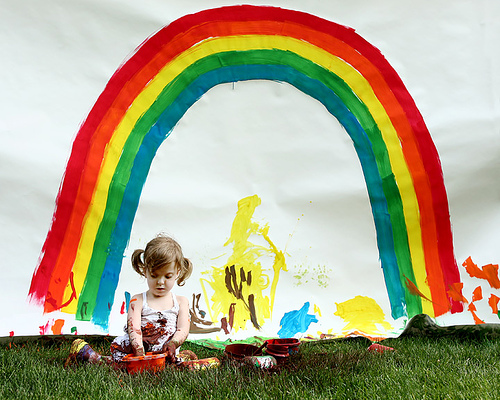

A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
A little girl is sitting in front of a large painted rainbow .
A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .
There is a girl with pigtails sitting in front of a rainbow painting .
Young girl with pigtails painting outside in the grass .


In [5]:
# displaying an image and captions given to it
temp = captions[10].split("#")
from IPython.display import Image, display
z = Image(filename=images_path+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])

In [6]:
# Creating train, test and validation dataset files with header as 'image_id' and 'captions'
train_dataset = open('flickr_8k_train_dataset.txt','wb')
train_dataset.write(b"image_id\tcaptions\n")

val_dataset = open('flickr_8k_val_dataset.txt','wb')
val_dataset.write(b"image_id\tcaptions\n")

test_dataset = open('flickr_8k_test_dataset.txt','wb')
test_dataset.write(b"image_id\tcaptions\n")

18

In [7]:
# Populating the above created files for train, test and validation dataset with image ids and captions for each of these images
for img in x_train:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        train_dataset.write((img+"\t"+caption+"\n").encode())
        train_dataset.flush()
train_dataset.close()

for img in x_test:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        test_dataset.write((img+"\t"+caption+"\n").encode())
        test_dataset.flush()
test_dataset.close()

for img in x_val:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        val_dataset.write((img+"\t"+caption+"\n").encode())
        val_dataset.flush()
val_dataset.close()

In [8]:
# Loading 50 layer Residual Network Model and getting the summary of the model
from IPython.core.display import display, HTML
display(HTML("""<a href="http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006">ResNet50 Architecture</a>"""))
model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')
model.summary()
# Note: For more details on ResNet50 architecture you can click on hyperlink given below

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
_____________________________________

In [9]:
# Helper function to process images
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [10]:
train_data = {}
ctr=0
for ix in x_train:
    if ix == "":
        continue
    if ctr >= 3000:
        break
    ctr+=1
    if ctr%1000==0:
        print(ctr)
    path = images_path + ix
    img = preprocessing(path)
    pred = model.predict(img).reshape(2048)
    train_data[ix] = pred

1000
2000
3000


In [11]:
train_data['2513260012_03d33305cf.jpg'].shape

(2048,)

In [12]:
# opening train_encoded_images.p file and dumping it's content
with open( "train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_data, pickle_f )

In [13]:
# Loading image and its corresponding caption into a dataframe and then storing values from dataframe into 'ds'
pd_dataset = pd.read_csv("flickr_8k_train_dataset.txt", delimiter='\t')
ds = pd_dataset.values
print(ds.shape)

(30000, 2)


In [14]:
pd_dataset.head()

,image_id,captions
0,2513260012_03d33305cf.jpg,<start> A black dog is running after a white d...
1,2513260012_03d33305cf.jpg,<start> Black dog chasing brown dog through sn...
2,2513260012_03d33305cf.jpg,<start> Two dogs chase each other across the s...
3,2513260012_03d33305cf.jpg,<start> Two dogs play together in the snow . <...
4,2513260012_03d33305cf.jpg,<start> Two dogs running through a low lying b...


In [15]:
# Storing all the captions from ds into a list
sentences = []
for ix in range(ds.shape[0]):
    sentences.append(ds[ix, 1])
    
print(len(sentences))

30000


In [16]:
# First 5 captions stored in sentences
sentences[:5]

['<start> A black dog is running after a white dog in the snow . <end>',
 '<start> Black dog chasing brown dog through snow <end>',
 '<start> Two dogs chase each other across the snowy ground . <end>',
 '<start> Two dogs play together in the snow . <end>',
 '<start> Two dogs running through a low lying body of water . <end>']

In [17]:
# Splitting each captions stored in 'sentences' and storing them in 'words' as list of list
words = [i.split() for i in sentences]

In [18]:
# Creating a list of all unique words
unique = []
for i in words:
    unique.extend(i)
unique = list(set(unique))

print(len(unique))

vocab_size = len(unique)

8253


In [19]:
# Vectorization
word_2_indices = {val:index for index, val in enumerate(unique)}
indices_2_word = {index:val for index, val in enumerate(unique)}
word_2_indices['UNK'] = 0
word_2_indices['raining'] = 8253
indices_2_word[0] = 'UNK'
indices_2_word[8253] = 'raining'
print(word_2_indices['<start>'])
print(indices_2_word[4011])
print(word_2_indices['<end>'])
print(indices_2_word[8051])

5713
straddles
4420
elbows


In [20]:
vocab_size = len(word_2_indices.keys())
print(vocab_size)

8254


In [21]:
max_len = 0

for i in sentences:
    i = i.split()
    if len(i) > max_len:
        max_len = len(i)

print(max_len)

40


In [22]:
padded_sequences, subsequent_words = [], []

for ix in range(ds.shape[0]):
    partial_seqs = []
    next_words = []
    text = ds[ix, 1].split()
    text = [word_2_indices[i] for i in text]
    for i in range(1, len(text)):
        partial_seqs.append(text[:i])
        next_words.append(text[i])
    padded_partial_seqs = sequence.pad_sequences(partial_seqs, max_len, padding='post')

    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
    
    #Vectorization
    for i,next_word in enumerate(next_words):
        next_words_1hot[i, next_word] = 1
        
    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)
    
padded_sequences = np.asarray(padded_sequences)
subsequent_words = np.asarray(subsequent_words)

print(padded_sequences.shape)
print(subsequent_words.shape)

(30000,)
(30000,)


In [23]:
print(padded_sequences[0])

[[5713    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [5713  240    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [5713  240 4840    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [5713  240 4840 7128    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [5713  240 4840 7128 1892    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [24]:
for ix in range(len(padded_sequences[0])):
    for iy in range(max_len):
        print(indices_2_word[padded_sequences[0][ix][iy]],)
    print("\n")

print(len(padded_sequences[0]))

<start>
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
dog
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
dog
is
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
dog
is
running
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<sta

In [25]:
num_of_images = 2000
captions = np.zeros([0, max_len])
next_words = np.zeros([0, vocab_size])

In [26]:
for ix in range(num_of_images):#img_to_padded_seqs.shape[0]):
    captions = np.concatenate([captions, padded_sequences[ix]])
    next_words = np.concatenate([next_words, subsequent_words[ix]])

np.save("captions.npy", captions)
np.save("next_words.npy", next_words)

print(captions.shape)
print(next_words.shape)

(25493, 40)
(25493, 8254)


In [27]:
f= open('train_encoded_images.p', 'rb')
encoded_images = pickle.load(f, encoding="bytes")

In [28]:
encoded_images.keys()


dict_keys(['2513260012_03d33305cf.jpg', '2903617548_d3e38d7f88.jpg', '3338291921_fe7ae0c8f8.jpg', '488416045_1c6d903fe0.jpg', '2644326817_8f45080b87.jpg', '218342358_1755a9cce1.jpg', '2501968935_02f2cd8079.jpg', '2699342860_5288e203ea.jpg', '2638369467_8fc251595b.jpg', '2926786902_815a99a154.jpg', '2851304910_b5721199bc.jpg', '3423802527_94bd2b23b0.jpg', '3356369156_074750c6cc.jpg', '2294598473_40637b5c04.jpg', '1191338263_a4fa073154.jpg', '2380765956_6313d8cae3.jpg', '3197891333_b1b0fd1702.jpg', '3119887967_271a097464.jpg', '2276499757_b44dc6f8ce.jpg', '2506892928_7e79bec613.jpg', '2187222896_c206d63396.jpg', '2826769554_85c90864c9.jpg', '3097196395_ec06075389.jpg', '3603116579_4a28a932e2.jpg', '3339263085_6db9fd0981.jpg', '2532262109_87429a2cae.jpg', '2076906555_c20dc082db.jpg', '2502007071_82a8c639cf.jpg', '3113769557_9edbb8275c.jpg', '3325974730_3ee192e4ff.jpg', '1655781989_b15ab4cbff.jpg', '1662261486_db967930de.jpg', '2410562803_56ec09f41c.jpg', '2469498117_b4543e1460.jpg', '6971

In [29]:
ds[0]

array(['2513260012_03d33305cf.jpg',
       '<start> A black dog is running after a white dog in the snow . <end>'],
      dtype=object)

In [30]:
imgs = []
for ix in range(ds.shape[0]):
    #print(ds[ix,0].encode())
    if ds[ix, 0] in encoded_images.keys():
        #print(ix, encoded_images[ds[ix, 0]])
        imgs.append(list(encoded_images[ds[ix, 0]]))
   # print("hi")

imgs = np.asarray(imgs)
print(imgs.shape)

(15000, 2048)


In [31]:
images = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        images.append(imgs[ix])
        
images = np.asarray(images)

np.save("images.npy", images)

print(images.shape)

(25493, 2048)


In [32]:
image_names = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        image_names.append(ds[ix, 0])
        
image_names = np.asarray(image_names)

np.save("image_names.npy", image_names)

print(len(image_names))

25493


In [33]:
captions = np.load("captions.npy")
next_words = np.load("next_words.npy")

print(captions.shape)
print(next_words.shape)

(25493, 40)
(25493, 8254)


In [34]:
images = np.load("images.npy")

print(images.shape)
(25493, 2048)
imag = np.load("image_names.npy")
        
print(imag.shape)

(25493, 2048)
(25493,)


In [35]:
embedding_size = 128
max_len = 40

In [36]:
image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               262272    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 40, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________


In [37]:
language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 128)           1056512   
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 256)           394240    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 128)           32896     
Total params: 1,483,648
Trainable params: 1,483,648
Non-trainable params: 0
_________________________________________________________________


In [38]:
conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_1_input (InputLayer)  (None, 40)           0                                            
__________________________________________________________________________________________________
dense_1_input (InputLayer)      (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 128)      1056512     embedding_1_input[0][0]          
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          262272      dense_1_input[0][0]              
__________________________________________________________________________________________________
lstm_1 (LS

In [109]:
hist = model.fit([images, captions], next_words, batch_size=1024, epochs=200)

Epoch 1/200
25493/25493 [==============================] - 90s 4ms/step - loss: 1.1573 - acc: 0.5960
Epoch 2/200
25493/25493 [==============================] - 90s 4ms/step - loss: 1.1474 - acc: 0.5966
Epoch 3/200
25493/25493 [==============================] - 91s 4ms/step - loss: 1.1120 - acc: 0.6088
Epoch 4/200
25493/25493 [==============================] - 91s 4ms/step - loss: 1.1165 - acc: 0.6042
Epoch 5/200
25493/25493 [==============================] - 90s 4ms/step - loss: 1.0923 - acc: 0.6162
Epoch 6/200
25493/25493 [==============================] - 90s 4ms/step - loss: 1.0789 - acc: 0.6226
Epoch 7/200
25493/25493 [==============================] - 91s 4ms/step - loss: 1.0606 - acc: 0.6281
Epoch 8/200
25493/25493 [==============================] - 90s 4ms/step - loss: 1.0389 - acc: 0.6314
Epoch 9/200
25493/25493 [==============================] - 90s 4ms/step - loss: 1.0356 - acc: 0.6341
Epoch 10/200
25493/25493 [==============================] - 90s 4ms/step - loss: 0.9997 - a

25493/25493 [==============================] - 90s 4ms/step - loss: 0.3171 - acc: 0.8851
Epoch 82/200
25493/25493 [==============================] - 90s 4ms/step - loss: 0.3678 - acc: 0.8665
Epoch 83/200
25493/25493 [==============================] - 90s 4ms/step - loss: 0.3451 - acc: 0.8761
Epoch 84/200
25493/25493 [==============================] - 90s 4ms/step - loss: 0.3109 - acc: 0.8855
Epoch 85/200
25493/25493 [==============================] - 90s 4ms/step - loss: 0.3535 - acc: 0.8709
Epoch 86/200
25493/25493 [==============================] - 90s 4ms/step - loss: 0.3667 - acc: 0.8675
Epoch 87/200
25493/25493 [==============================] - 90s 4ms/step - loss: 0.3149 - acc: 0.8848
Epoch 88/200
25493/25493 [==============================] - 90s 4ms/step - loss: 0.3082 - acc: 0.8856
Epoch 89/200
25493/25493 [==============================] - 89s 4ms/step - loss: 0.3451 - acc: 0.8760
Epoch 90/200
25493/25493 [==============================] - 90s 4ms/step - loss: 0.3361 - acc: 

25493/25493 [==============================] - 90s 4ms/step - loss: 0.2310 - acc: 0.9066
Epoch 161/200
25493/25493 [==============================] - 90s 4ms/step - loss: 0.2267 - acc: 0.9086
Epoch 162/200
25493/25493 [==============================] - 90s 4ms/step - loss: 0.2417 - acc: 0.9035
Epoch 163/200
25493/25493 [==============================] - 90s 4ms/step - loss: 0.2187 - acc: 0.9096
Epoch 164/200
25493/25493 [==============================] - 90s 4ms/step - loss: 0.2313 - acc: 0.9065
Epoch 165/200
25493/25493 [==============================] - 90s 4ms/step - loss: 0.2516 - acc: 0.8981
Epoch 166/200
25493/25493 [==============================] - 90s 4ms/step - loss: 0.2140 - acc: 0.9123
Epoch 167/200
25493/25493 [==============================] - 89s 4ms/step - loss: 0.2502 - acc: 0.8997
Epoch 168/200
25493/25493 [==============================] - 90s 4ms/step - loss: 0.2139 - acc: 0.9115
Epoch 169/200
25493/25493 [==============================] - 90s 4ms/step - loss: 0.235

In [110]:
model.save_weights("model_weights.h5")

In [74]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [111]:
def get_encoding(model, img):
    image = preprocessing(img)
    pred = model.predict(image).reshape(2048)
    return pred

In [76]:
resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

In [112]:
img = "Flickr_Data/Flickr_Data/Images/1453366750_6e8cf601bf.jpg"

test_img = get_encoding(resnet, img)

In [113]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word_2_indices[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = indices_2_word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])



In [114]:
Argmax_Search = predict_captions(test_img)

In [115]:
test_captions = list()
for i in x_test:
    if i in tokens:
        test_captions.append(tokens[i])
        
print(test_captions)

[['The dogs are in the snow in front of a fence .', 'The dogs play on the snow .', 'Two brown dogs playfully fight in the snow .', 'Two brown dogs wrestle in the snow .', 'Two dogs playing in the snow .'], ['a brown and white dog swimming towards some in the pool', 'A dog in a swimming pool swims toward sombody we cannot see .', 'A dog swims in a pool near a person .', 'Small dog is paddling through the water in a pool .', 'The small brown and white dog is in the pool .'], ['A man and a woman in festive costumes dancing .', 'A man and a woman with feathers on her head dance .', 'A man and a woman wearing decorative costumes and dancing in a crowd of onlookers .', 'one performer wearing a feathered headdress dancing with another performer in the streets', 'Two people are dancing with drums on the right and a crowd behind them .'], ['A couple of people sit outdoors at a table with an umbrella and talk .', 'Three people are sitting at an outside picnic bench with an umbrella .', 'Three pe

In [116]:
predicted_captions = list()
for i in x_test:
    if i is not "":
        img_path = "Flickr_Data/Flickr_Data/Images/"+ i
        test_img = get_encoding(resnet, img_path)
        print(img_path)
        predicted_captions.append(predict_captions(test_img))
    
predicted_captions

Flickr_Data/Flickr_Data/Images/3385593926_d3e9c21170.jpg
Flickr_Data/Flickr_Data/Images/2677656448_6b7e7702af.jpg
Flickr_Data/Flickr_Data/Images/311146855_0b65fdb169.jpg
Flickr_Data/Flickr_Data/Images/1258913059_07c613f7ff.jpg
Flickr_Data/Flickr_Data/Images/241347760_d44c8d3a01.jpg
Flickr_Data/Flickr_Data/Images/2654514044_a70a6e2c21.jpg
Flickr_Data/Flickr_Data/Images/2339106348_2df90aa6a9.jpg
Flickr_Data/Flickr_Data/Images/256085101_2c2617c5d0.jpg
Flickr_Data/Flickr_Data/Images/280706862_14c30d734a.jpg
Flickr_Data/Flickr_Data/Images/3072172967_630e9c69d0.jpg
Flickr_Data/Flickr_Data/Images/3482062809_3b694322c4.jpg
Flickr_Data/Flickr_Data/Images/1167669558_87a8a467d6.jpg
Flickr_Data/Flickr_Data/Images/2847615962_c330bded6e.jpg
Flickr_Data/Flickr_Data/Images/3344233740_c010378da7.jpg
Flickr_Data/Flickr_Data/Images/2435685480_a79d42e564.jpg
Flickr_Data/Flickr_Data/Images/3110649716_c17e14670e.jpg
Flickr_Data/Flickr_Data/Images/2511019188_ca71775f2d.jpg
Flickr_Data/Flickr_Data/Images/2521

Flickr_Data/Flickr_Data/Images/2346401538_f5e8da66fc.jpg
Flickr_Data/Flickr_Data/Images/3605676864_0fb491267e.jpg
Flickr_Data/Flickr_Data/Images/3658427967_6e2e57458d.jpg
Flickr_Data/Flickr_Data/Images/2868575889_2c030aa8ae.jpg
Flickr_Data/Flickr_Data/Images/3494394662_3edfd4a34c.jpg
Flickr_Data/Flickr_Data/Images/3452127051_fa54a902b3.jpg
Flickr_Data/Flickr_Data/Images/3143155555_32b6d24f34.jpg
Flickr_Data/Flickr_Data/Images/470373679_98dceb19e7.jpg
Flickr_Data/Flickr_Data/Images/542317719_ed4dd95dc2.jpg
Flickr_Data/Flickr_Data/Images/2844641033_dab3715a99.jpg
Flickr_Data/Flickr_Data/Images/2588927489_f4da2f11ec.jpg
Flickr_Data/Flickr_Data/Images/2041867793_552819a40b.jpg
Flickr_Data/Flickr_Data/Images/2594042571_2e4666507e.jpg
Flickr_Data/Flickr_Data/Images/493109089_468e105233.jpg
Flickr_Data/Flickr_Data/Images/3109704348_c6416244ce.jpg
Flickr_Data/Flickr_Data/Images/241345811_46b5f157d4.jpg
Flickr_Data/Flickr_Data/Images/3457045393_2bbbb4e941.jpg
Flickr_Data/Flickr_Data/Images/2797

Flickr_Data/Flickr_Data/Images/2431470169_0eeba7d602.jpg
Flickr_Data/Flickr_Data/Images/3099923914_fd450f6d51.jpg
Flickr_Data/Flickr_Data/Images/524105255_b346f288be.jpg
Flickr_Data/Flickr_Data/Images/56489627_e1de43de34.jpg
Flickr_Data/Flickr_Data/Images/2587818583_4aa8e7b174.jpg
Flickr_Data/Flickr_Data/Images/460935487_75b2da7854.jpg
Flickr_Data/Flickr_Data/Images/3316725440_9ccd9b5417.jpg
Flickr_Data/Flickr_Data/Images/2573625591_70291c894a.jpg
Flickr_Data/Flickr_Data/Images/3030566410_393c36a6c5.jpg
Flickr_Data/Flickr_Data/Images/1131800850_89c7ffd477.jpg
Flickr_Data/Flickr_Data/Images/3375549004_beee810e60.jpg
Flickr_Data/Flickr_Data/Images/2470486377_c3a39ccb7b.jpg
Flickr_Data/Flickr_Data/Images/436009777_440c7679a1.jpg
Flickr_Data/Flickr_Data/Images/2862004252_53894bb28b.jpg
Flickr_Data/Flickr_Data/Images/3361990489_92244a58ef.jpg
Flickr_Data/Flickr_Data/Images/293879742_5fe0ffd894.jpg
Flickr_Data/Flickr_Data/Images/3203453897_6317aac6ff.jpg
Flickr_Data/Flickr_Data/Images/177285

Flickr_Data/Flickr_Data/Images/1659358141_0433c9bf99.jpg
Flickr_Data/Flickr_Data/Images/2533642917_a5eace85e6.jpg
Flickr_Data/Flickr_Data/Images/2204550058_2707d92338.jpg
Flickr_Data/Flickr_Data/Images/2764178773_d63b502812.jpg
Flickr_Data/Flickr_Data/Images/180094434_b0f244832d.jpg
Flickr_Data/Flickr_Data/Images/2308978137_bfe776d541.jpg
Flickr_Data/Flickr_Data/Images/3358682439_be4b83544c.jpg
Flickr_Data/Flickr_Data/Images/2602085456_d1beebcb29.jpg
Flickr_Data/Flickr_Data/Images/2589241160_3832440850.jpg
Flickr_Data/Flickr_Data/Images/421322723_3470543368.jpg
Flickr_Data/Flickr_Data/Images/2124040721_bffc0a091a.jpg
Flickr_Data/Flickr_Data/Images/3145967309_b33abe4d84.jpg
Flickr_Data/Flickr_Data/Images/300550441_f44ec3701a.jpg
Flickr_Data/Flickr_Data/Images/1584315962_5b0b45d02d.jpg
Flickr_Data/Flickr_Data/Images/2460797929_66446c13db.jpg
Flickr_Data/Flickr_Data/Images/2909875716_25c8652614.jpg
Flickr_Data/Flickr_Data/Images/3085667865_fa001816be.jpg
Flickr_Data/Flickr_Data/Images/362

Flickr_Data/Flickr_Data/Images/3716244806_97d5a1fb61.jpg
Flickr_Data/Flickr_Data/Images/3641022607_e7a5455d6c.jpg
Flickr_Data/Flickr_Data/Images/2950905787_f2017d3e49.jpg
Flickr_Data/Flickr_Data/Images/3482974845_db4f16befa.jpg
Flickr_Data/Flickr_Data/Images/2883099128_0b056eed9e.jpg
Flickr_Data/Flickr_Data/Images/2310126952_7dc86d88f6.jpg
Flickr_Data/Flickr_Data/Images/2479162876_a5ce3306af.jpg
Flickr_Data/Flickr_Data/Images/3498997518_c2b16f0a0e.jpg
Flickr_Data/Flickr_Data/Images/3232470286_903a61ea16.jpg
Flickr_Data/Flickr_Data/Images/2183227136_8bb657846b.jpg
Flickr_Data/Flickr_Data/Images/2120383553_5825333a3f.jpg
Flickr_Data/Flickr_Data/Images/3544793763_b38546a5e8.jpg
Flickr_Data/Flickr_Data/Images/1404832008_68e432665b.jpg
Flickr_Data/Flickr_Data/Images/3541474181_489f19fae7.jpg
Flickr_Data/Flickr_Data/Images/3042380610_c5ea61eef8.jpg
Flickr_Data/Flickr_Data/Images/486917990_72bd4069af.jpg
Flickr_Data/Flickr_Data/Images/2599444370_9e40103027.jpg
Flickr_Data/Flickr_Data/Images/3

Flickr_Data/Flickr_Data/Images/53043785_c468d6f931.jpg
Flickr_Data/Flickr_Data/Images/3058439373_9276a4702a.jpg
Flickr_Data/Flickr_Data/Images/2100816230_ff866fb352.jpg
Flickr_Data/Flickr_Data/Images/2729655904_1dd01922fb.jpg
Flickr_Data/Flickr_Data/Images/3270691950_88583c3524.jpg
Flickr_Data/Flickr_Data/Images/3729525173_7f984ed776.jpg
Flickr_Data/Flickr_Data/Images/540721368_12ac732c6c.jpg
Flickr_Data/Flickr_Data/Images/3686924335_3c51e8834a.jpg
Flickr_Data/Flickr_Data/Images/2295216243_0712928988.jpg
Flickr_Data/Flickr_Data/Images/3450874870_c4dcf58fb3.jpg
Flickr_Data/Flickr_Data/Images/3061481868_d1e00b1f2e.jpg
Flickr_Data/Flickr_Data/Images/308487515_7852928f90.jpg
Flickr_Data/Flickr_Data/Images/263854883_0f320c1562.jpg
Flickr_Data/Flickr_Data/Images/3549583146_3e8bb2f7e9.jpg
Flickr_Data/Flickr_Data/Images/3542484764_77d8920ec9.jpg
Flickr_Data/Flickr_Data/Images/3208074567_ac44aeb3f3.jpg
Flickr_Data/Flickr_Data/Images/3167365436_c379bda282.jpg
Flickr_Data/Flickr_Data/Images/26934

Flickr_Data/Flickr_Data/Images/2890113532_ab2003d74e.jpg
Flickr_Data/Flickr_Data/Images/1456393634_74022d9056.jpg
Flickr_Data/Flickr_Data/Images/2813033949_e19fa08805.jpg
Flickr_Data/Flickr_Data/Images/745880539_cd3f948837.jpg
Flickr_Data/Flickr_Data/Images/2480327661_fb69829f57.jpg
Flickr_Data/Flickr_Data/Images/3125309108_1011486589.jpg
Flickr_Data/Flickr_Data/Images/3287549827_04dec6fb6e.jpg
Flickr_Data/Flickr_Data/Images/391579205_c8373b5411.jpg
Flickr_Data/Flickr_Data/Images/2610447973_89227ff978.jpg
Flickr_Data/Flickr_Data/Images/2698666984_13e17236ae.jpg
Flickr_Data/Flickr_Data/Images/339350939_6643bfb270.jpg
Flickr_Data/Flickr_Data/Images/127490019_7c5c08cb11.jpg
Flickr_Data/Flickr_Data/Images/1714316707_8bbaa2a2ba.jpg
Flickr_Data/Flickr_Data/Images/3556598205_86c180769d.jpg
Flickr_Data/Flickr_Data/Images/757046028_ff5999f91b.jpg
Flickr_Data/Flickr_Data/Images/132489044_3be606baf7.jpg
Flickr_Data/Flickr_Data/Images/3613800013_5a54968ab0.jpg
Flickr_Data/Flickr_Data/Images/257797

['A dogs running in a orange in a beach .',
 'A surfer in the incoming to an small is to a small small on a beach .',
 'A woman holding the white shirt is plays in a red in a red helmet on a red helmet .',
 'A bald woman and three in a bandanna walks from a graffited backside building in a bicycles .',
 'A guy in a red basketball on a court with his on his shirt on his hand .',
 'A dog leaps in the field .',
 'Three people are posing for a picture .',
 'A brown dog has a grass on camera .',
 'A black dog in the water with a mouth .',
 'A group of cheerleaders are wearing green by fight and a picture .',
 'A group girls are standing on a something in a brick wall .',
 'A woman wearing a hat holds a book .',
 'A black dog walks with a fallen beach .',
 'Three young people are are guitars in a small all with a people and coffee and a blond .',
 'A man in cots cots hanging with a cliff .',
 'A man looking looking at a stroller walking of and a cut-out head while .',
 'A dog in a ball in a 

In [56]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu

In [117]:
# bleu score
score1 = corpus_bleu(test_captions, predicted_captions)
score2 = sentence_bleu(test_captions, predicted_captions)

In [118]:
print(score1, score2)

0.4601193578307381 3.2397263153811994e-232


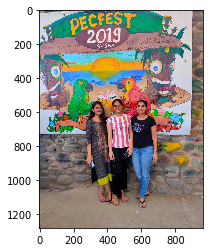

A group of adults walk in a karate tournament .


In [137]:
img_name = "c.jpeg"
test_img = get_encoding(resnet,img_name)
caption = predict_captions(test_img)
x= plt.imread(img_name)
plt.imshow(x)
plt.show()
print(caption)

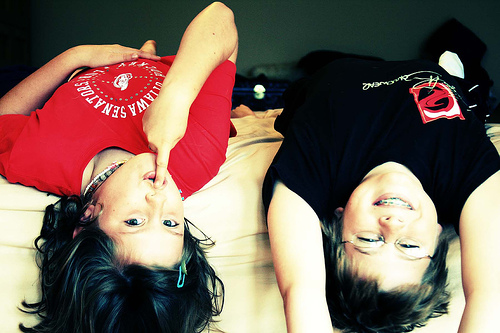

Two teen girls hang upside down on bed .


In [88]:
z = Image(filename=img)
display(z)

print(Argmax_Search)